<a href="https://colab.research.google.com/github/AndresMontesDeOca/TimeSeries/blob/main/TP1_Ale_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP #1


# 0. Inicializacion

## 0.1 Carga de Librerias

In [1]:
!pip install pmdarima
!pip install pingouin

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import warnings
import matplotlib.pyplot as plt
import pingouin as pg
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose



# Ignorar las advertencias específicas de statsmodels
# from statsmodels.tools.sm_exceptions import ValueWarning
# warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore')

# Vamos a suprimir la notacion cientifica
pd.set_option("display.float_format", lambda x:"%.2f" %x)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7028 sha256=48c676c0db247d4344ce66e7c8cba00085148609bf42cdaed1425edeea325281
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


Importamos la Serie

Como tenemos la serie en el Drive, tenemos que improtar una serie de librerias para poder levantar la serie

No olvidar dar los permisos al archivo para poder leer desde el jpynb el mismo.
Luego, copiamso la ruta al archivo, pero solo nos quedamos con el id para acceder al mismo, a continuacion se copia la ruta completa al archivo

https://drive.google.com/file/d/1cuyeVtIy_DOtiADp5cHwNsucJpzhaBqG/view?usp=share_link


Siempre que tenga que leer un archivo que esta en un drive, copiar esta ruta

## 0.2 Carga de Datos

In [2]:
# Code to read csv file into Colaboratory:
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

################################# Datasets ###################################
# Air Pasangers
id = "1LV2t7HpwYpxSumUywyRE1wZ2xyF1KF5I"
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('DemHoraria_v2.csv')
dataD = pd.read_csv("DemHoraria_v2.csv", sep=",") # Cargamos el Dataset
data = dataD
######################################################################
# Temperatura
id = "1Lji7usex9EBPQpTgUhAdI6oRnJN9pAxf"
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('SerieT20_2022.csv')
dataT = pd.read_csv("SerieT20_2022.csv") # Cargamos el Dataset
######################################################################
# Demanda, Viento, Temperatura ya procesados y unidos en un solo DataFrame
id = "1Lk9Ib0cVa7vtsLXYjycjktIIhBzS3zdX"
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('data_DTV.csv')
dataDVT = pd.read_csv("data_DTV.csv", parse_dates=['Fecha'], index_col='Fecha') # Cargamos el Dataset

# 1. Preprocesamiento

## 1.1 DataFrame data (Demanda y Viento)

In [3]:
# Convertimos la columna "data_hora" a tipo de datos de fecha y hora
data["data_hora"]= pd.to_datetime(data["data_hora"], format="%Y-%m-%d %H")

# Renombramos las variables
data.rename(columns={"Demanda_MW": "Demanda", "data_hora":"Fecha", "Vel_viento": "Viento"}, inplace=True)

# Seteamos la Fecha como Index
data=data.set_index("Fecha")

# Filtrar los datos para los años 2020, 2021 y 2022
data = data['2020':'2022']

# Dividimos el DataFrame
dataD = data[['Demanda']]
dataV = data[['Viento']]

# display(data.head())
# display(dataD.head())
# display(dataV.head())

## 1.2 DataFrame dataT (Temperatura)

In [4]:
# Eliminamos Nulos
dataT = dataT.dropna()

# Renombramos las variables
dataT.rename(columns={"TempAire": "Temperatura"}, inplace=True)

# Convertimos la columna "Fecha" a tipo de datos de fecha y hora
dataT["Fecha"]= pd.to_datetime(dataT["Fecha"], format='%m/%d/%Y %H:%M')

# Seteamos la Fecha como Index
dataT=dataT.set_index("Fecha")

# print(dataT.describe())

## 1.3 Analisis de Demanda

### 1.3.1 Limpeza de Valores Atipicos
Ya no es necesario porque filtramos por ano 2020, 2021, y 2022

In [5]:
# Poniendo en nulos los valores menores a 83 o mayores a 2300
dataD['Demanda'] = dataD['Demanda'].apply(lambda x: x if (x >= 83 and x <= 2300) else None)

# Realizando backfill para llenar los valores nulos/fuera de rabgo
dataD['Demanda'].fillna(method='backfill', inplace=True)

# Al recortar el Dataset original a los datos de los anos 2020, 2021 y 2022, esto ya no es necesario

### 1.3.2 Agregacion por Dia

In [6]:
# Tener el corte por hora no tiene mucho sentido para el Analisis
# Ademas, las notebook corren muy lento con tantos datos

# El corte por hora es muy atomizado, agregamos por dia
dataD_daily = dataD['Demanda'].resample('D').sum()

# Seguimos con la variable dataD
dataD = dataD_daily.to_frame() # Lo paso a Pandas DataFrame, sino me lo transforma a Pandas Series

## 1.4 Analisis del Viento

In [7]:
# Corregimos los valores rotos, ponemos en null los > a 100
dataV.loc[dataV['Viento'] > 100, 'Viento'] = None

# Completar los valores nulos con el método backfill en dataV_filtered
dataV.fillna(method='bfill', inplace=True)

# Calcular el promedio diario del viento
dataV = dataV.resample('D').mean()

## 1.4 Analisis de la Temperatura

In [8]:
# Completar los valores nulos con el método backfill
dataT.fillna(method='bfill', inplace=True)

# Agregar por Average o Maximo diario
dataT = dataT.resample('D').mean()

## 1.5 Union Datasets

In [10]:
# Comparar los índices de data1 y data3 para encontrar diferencias
differences = dataD.index.difference(dataT.index)

# Crear un nuevo DataFrame con los índices faltantes y todas las columnas en NaN
missing_indices = pd.DataFrame(index=differences)

# Unir este nuevo DataFrame con data3, manteniendo todos los valores de data3 y poniendo NaN en los valores faltantes
dataT = dataT.combine_first(missing_indices)

# Ordenar el DataFrame por el índice
dataT.sort_index(inplace=True)

# Comparar los índices de data1, data2 y data3 para verificar si son iguales
indices_equal = (dataD.index.equals(dataV.index) and dataV.index.equals(dataT.index))
print('Indices sincronizados:', indices_equal)

# Concatenacion, Todavia no, primero tengo que curar cara serie por separado
data = pd.concat([dataD, dataV, dataT], axis=1)

print(data.info())
display(data.head())

Indices sincronizados: True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2020-01-01 to 2022-12-31
Freq: D
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Demanda      1096 non-null   float64
 1   Viento       1096 non-null   float64
 2   Temperatura  1096 non-null   float64
dtypes: float64(3)
memory usage: 34.2 KB
None


,Demanda,Viento,Temperatura
Fecha,,,
2020-01-01,24206.06,12.64,21.15
2020-01-02,28478.32,17.04,21.25
2020-01-03,29702.44,18.04,21.81
2020-01-04,28617.39,16.59,21.31
2020-01-05,28215.97,16.60,23.75


## 1.6 Funciones Auxiliares

### 1.6.1 Funcion "estacionariedad"
Test Analitico de ADF

In [ ]:
# Funciones Auxiliares para el Analisis Analitco de Estacionariedad
# Mepa que es lo mismo que ADFTest de  pmdarima

from statsmodels.tsa.stattools import adfuller

# Augmented Dickey–Fuller test
def estacioneriedad(y):
  resultado = adfuller(y)
  # print('Estadistico ADF: %f' % resultado[0])
  print('p-valor: %f' % resultado[1])
  # print('Valores criticos:')
  # for key, valor in resultado[4].items():
  #   print('\t%s: %.3f' % (key, valor))
  if resultado[1] < 0.05:
    print('Serie Estacionaria')
  else:
    print('Serie no Estacionaria')

### 1.6.2 Funcion "diferenciacion"
Distintos tests que devuelven el d optimo para diferenciar

In [ ]:
# Para obtener el d optimo a diferenciar
def diferenciacion(y):
  # Estimado de número de diferencias con ADF test:Dickey-Fuller
  n_adf = ndiffs(y, test='adf')  # -> 0

  # KPSS test (auto_arima default): Kwiatkowski-Phillips-Schmidt-Shin
  n_kpss = ndiffs(y, test='kpss')  # -> 0

  # PP test: Phillips-Perron
  n_pp = ndiffs(y, test='pp')  # -> 0

  print('Estimado de número de diferencias con KPSS test')
  print(n_kpss)


  print('Estimado de número de diferencias con ADF test')
  print(n_adf)

  print('Estimado de número de diferencias con PP test')
  print(n_pp)

  # print('Se debe realizar diferenciación (should_diff) ADF Test')
  # adftest = ADFTest(alpha=0.05)
  # print(adftest.should_diff(y))

# 2. Graficar las series originales
- Analizar si es necesario diferenciarlas para convertirlas en estacionarias
- Exponer los conceptos relacionados con la estacionariedad de la serie.

## 2.1 Visualizacion Individual de las Series

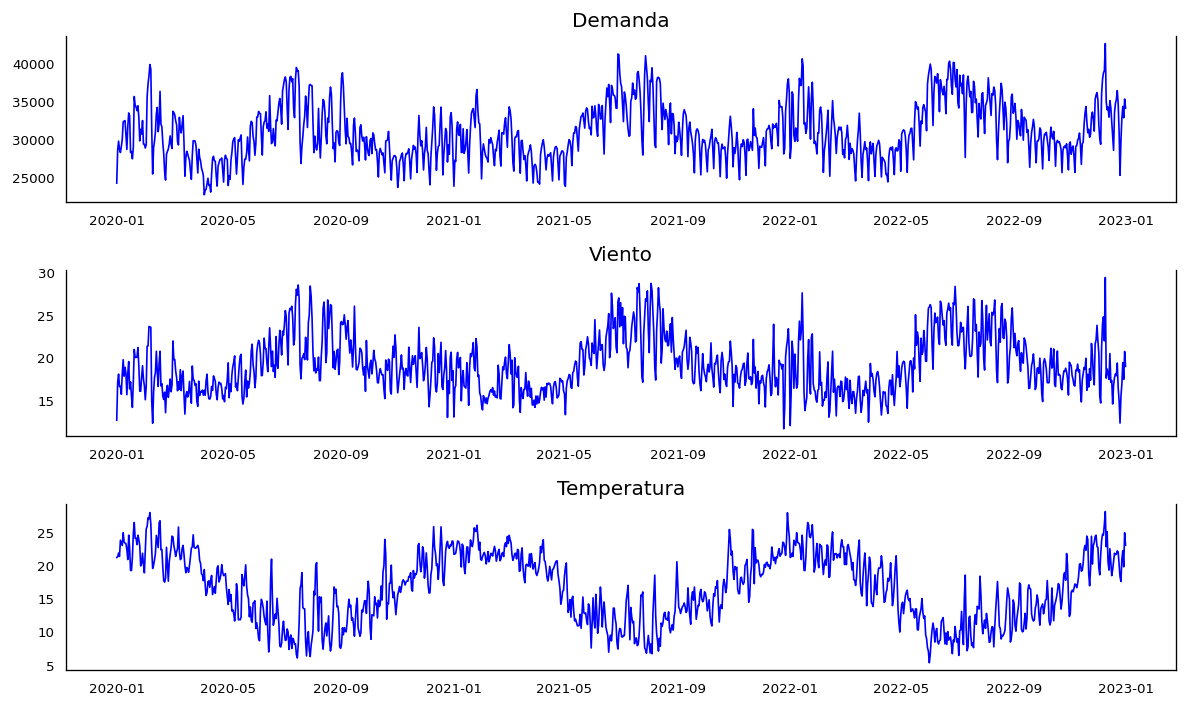

In [14]:
# Plot each time series in the dataset
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data_column = data.columns[i]
    ax.plot(data[data_column], color='blue', linewidth=1)
    # Decorate
    ax.set_title(data_column)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=8)

plt.tight_layout();

## 2.2 Visualizacion Conjunta de las Series

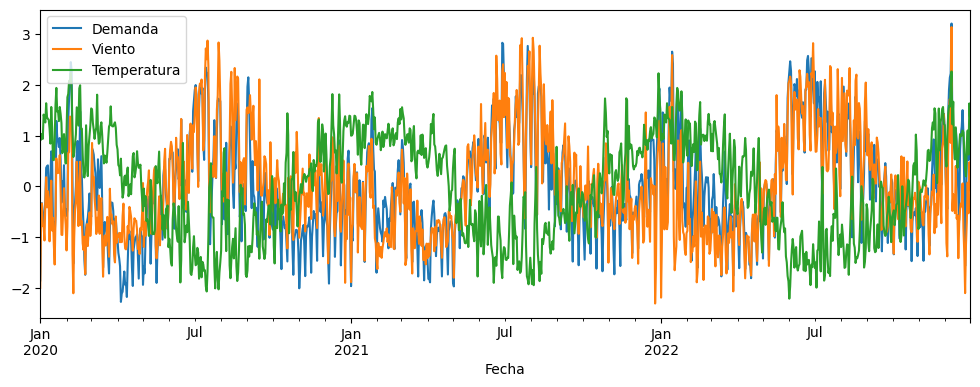

In [15]:
# Normalizamos para comprar las tres series en un solo plot
from scipy.stats import zscore

datN = data.apply(zscore)

datN.plot(figsize=(12, 4))
plt.show()

- Pareciera ser que Demanda y Viento estan muy correlacionadas
- Tambien pareciera ser que la Demanda y la Temperatura estan inversamente relacionadas, osea que la Demanda de energia parece ser mayor el invierno, para calefaccionarse que en verano por el aire acondicionado

## 2.3 NUSE

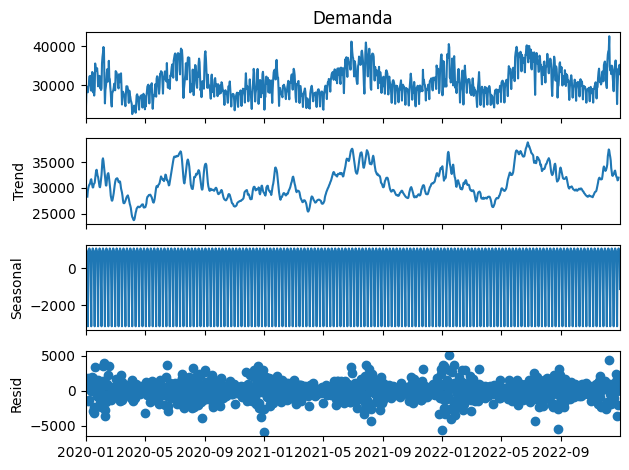

In [ ]:
# Since we have daily data, let's assume a weekly seasonality for demonstration
decompose_demanda = seasonal_decompose(data['Demanda'], model='additive', period=7)
decompose_demanda.plot()
plt.show()

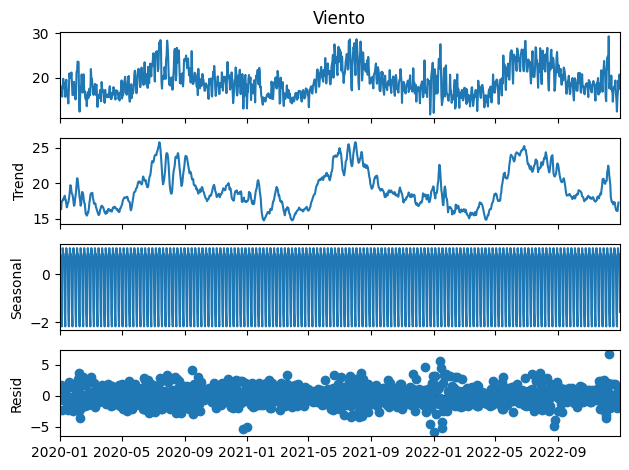

In [ ]:
# Viento
decompose_viento = seasonal_decompose(data['Viento'], model='additive', period=7)
decompose_viento.plot()
plt.show()

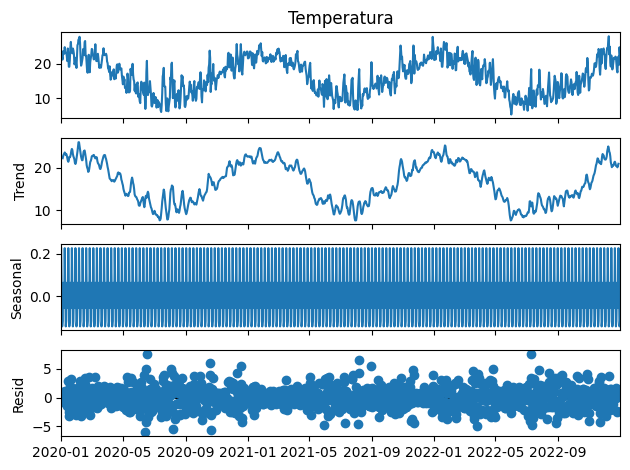

In [ ]:
# Temperatura
decompose_temperatura = seasonal_decompose(data['Temperatura'], model='additive', period=7)
decompose_temperatura.plot()
plt.show()


# 3. Graficar la FAS, FAC y FACP

In [ ]:
# Graficamos las Funciones de Autocorrelacion

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF y PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# ACF
plot_acf(data['Demanda'], ax=ax1, lags=50)
ax1.set_title('Autocorrelation Function')

# PACF
plot_pacf(data['Demanda'], ax=ax2, lags=50)
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

- Del Grafico de Partial-Autocorrelacion (PACF) podemos concluir que la Serie tiene un pico en el lag 1, lo que indica que una Diferenciacion de Orden 1 es recomendable
- Del grarfico Autocorrelacion (ACF) concluimos que la Serie tiene un Trend decreciente, como asi tambien se observan unos valles, lo que indica tambien que la Serie puede tener un componente de Estacionalidad

# 4. Realizar distintas pruebas de raíces unitarias

In [ ]:
# Tests Analiticos de Diferenciacion

# !pip install -q arch
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

kpss_pvalue = kpss(data)[1]
adf_pvalue = adfuller(data)[1]
pp = PhillipsPerron(data)

print('p-values de los distintos test:\n')
print('KPSS (Kwiatkowski-Phillips-Schmidt-Shin)', kpss_pvalue)
print('Dickey-Fuller Aumentada (ADF):', np.round(adf_pvalue, 4), '\n')
print(pp)



- La H0 del test de KPSS indica la estacionariedad, la cual rechazamos con un p-value obtenido del 0.01%
- En cambio los tests de ADF y PP, con ambos p-values casi del 0%, rechazan la H0 de no-estacionariedad
- Los diferentes test nos arrojan valores contradictorios


# 5. Estimaciones con distintos parametros en SARIMA
PENDIENTE


In [ ]:
# Analizamos la descomposicion de la Serie

from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(14, 6))
seasonal_decompose(data['Demanda'], model='additive', period=12).plot()
plt.show()

- Se observa tanto Trend como Estacionalidad, la serie no es Estacionaria
- Es recomendable Diferenciar la serie de alguna manera, antes de aplicar SARIMA